# Bootcamp Sesión 1 
### Descarga datos | IQR y Outliers | Filtro de Kalman
Septiembre 2024


In [1]:
import requests 
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
load_dotenv()
%matplotlib inline

## Seleccionar mercado de FX

API_KEY = os.environ['FMP']

#### Tema 1: Descarga de Datos Intradía

In [2]:
r = requests.get(f'https://financialmodelingprep.com/api/v3/historical-chart/5min/EURUSD?from=2024-09-01&to=2024-09-23&apikey={API_KEY}')

In [3]:
values = r.json()

In [4]:
df = pd.DataFrame(values)
df = df.assign(ticker = 'EURUSD')

In [5]:
df.head()

,date,open,low,high,close,volume,ticker
0,2024-09-23 23:55:00,1.11127,1.11122,1.11128,1.11125,351,EURUSD
1,2024-09-23 23:50:00,1.11127,1.11125,1.11136,1.11127,239,EURUSD
2,2024-09-23 23:45:00,1.11126,1.11115,1.11131,1.11127,311,EURUSD
3,2024-09-23 23:40:00,1.11116,1.11113,1.11126,1.11126,201,EURUSD
4,2024-09-23 23:35:00,1.11118,1.11100,1.11118,1.11116,440,EURUSD


In [6]:
df.describe()

,open,low,high,close,volume
count,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000
mean,1.113165,1.113007,1.113323,1.113167,836.114745
std,0.002342,0.002330,0.002351,0.002339,759.892269
min,1.107020,1.106840,1.107470,1.107020,2.000000
25%,1.111685,1.111550,1.111840,1.111685,358.000000
50%,1.112600,1.112460,1.112760,1.112600,704.000000
75%,1.115790,1.115640,1.115910,1.115790,1046.500000
max,1.118680,1.117810,1.118890,1.118680,9062.000000


In [7]:
# Ejecutar una sola vez debido al parametro inplace
df.set_index('date', inplace=True)

In [8]:
df.head()

,open,low,high,close,volume,ticker
date,,,,,,
2024-09-23 23:55:00,1.11127,1.11122,1.11128,1.11125,351,EURUSD
2024-09-23 23:50:00,1.11127,1.11125,1.11136,1.11127,239,EURUSD
2024-09-23 23:45:00,1.11126,1.11115,1.11131,1.11127,311,EURUSD
2024-09-23 23:40:00,1.11116,1.11113,1.11126,1.11126,201,EURUSD
2024-09-23 23:35:00,1.11118,1.11100,1.11118,1.11116,440,EURUSD


<Axes: xlabel='date'>

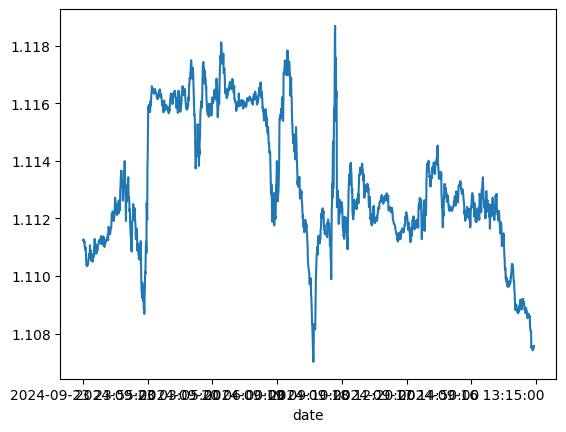

In [9]:
## Revisar serie de tiempo
df['close'].plot(kind='line')

<Axes: xlabel='date'>

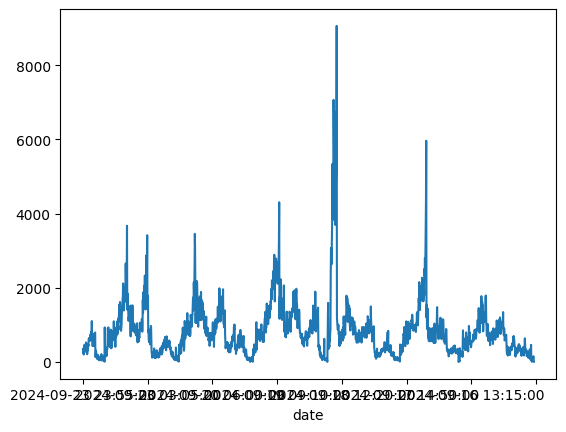

In [10]:
df['volume'].plot(kind='line')

#### Tema 2: IQR

El Rango Intercuartílico (IQR) es una técnica común para la detección de outliers (valores atípicos) en los datos. Se basa en la diferencia entre el tercer cuartil (Q3) y el primer cuartil (Q1) de una distribución, y cualquier punto que esté significativamente por encima o por debajo de este rango puede considerarse un outlier.

La fórmula básica para identificar outliers es:

Límite inferior=𝑄1−1.5×IQR 

Límite superior = 𝑄3+1.5×IQR 

Cualquier valor fuera de estos límites puede ser considerado un outlier.

In [11]:
# Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
Q1 = df['volume'].quantile(0.25)
Q3 = df['volume'].quantile(0.75)

# Calcular IQR
IQR = Q3 - Q1

# Definir los límites inferior y superior para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Límite inferior: {lower_bound}")
print(f"Límite superior: {upper_bound}")

# Filtrar los valores que son considerados outliers
outliers = df[(df['volume'] < lower_bound) | (df['volume'] > upper_bound)]

print("Outliers detectados:")
print(outliers)

Límite inferior: -674.75
Límite superior: 2079.25
Outliers detectados:
                        open      low     high    close  volume  ticker
date                                                                   
2024-09-23 11:00:00  1.11323  1.11276  1.11344  1.11276    2118  EURUSD
2024-09-23 10:10:00  1.11191  1.11185  1.11244  1.11242    2657  EURUSD
2024-09-23 10:05:00  1.11265  1.11152  1.11272  1.11191    2228  EURUSD
2024-09-23 10:00:00  1.11293  1.11256  1.11312  1.11265    2127  EURUSD
2024-09-23 09:50:00  1.11259  1.11227  1.11280  1.11272    2443  EURUSD
...                      ...      ...      ...      ...     ...     ...
2024-09-17 08:50:00  1.11208  1.11178  1.11248  1.11242    2218  EURUSD
2024-09-17 08:45:00  1.11238  1.11193  1.11265  1.11208    2846  EURUSD
2024-09-17 08:40:00  1.11212  1.11199  1.11261  1.11238    3645  EURUSD
2024-09-17 08:35:00  1.11252  1.11211  1.11299  1.11212    4333  EURUSD
2024-09-17 08:30:00  1.11336  1.11212  1.11437  1.11252    5965  

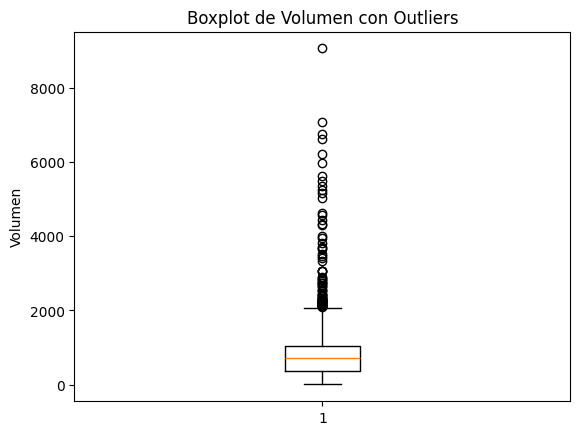

In [12]:
# Crear un boxplot para visualizar los outliers
plt.boxplot(df['volume'])

# Etiquetas y título
plt.title('Boxplot de Volumen con Outliers')
plt.ylabel('Volumen')
plt.show()

##### Objetivo crear un vector de anomalia ascendente

In [13]:
qz = df['volume'].quantile(0.95)
vol_high = df[df['volume'] > qz]

<Axes: xlabel='date'>

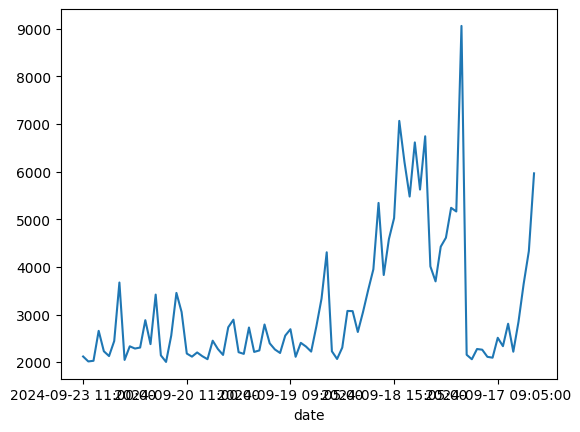

In [14]:
vol_high['volume'].plot(kind='line')

In [15]:
vol_high['volume'].head(60)

date
2024-09-23 11:00:00    2118
2024-09-23 10:35:00    2014
2024-09-23 10:15:00    2028
2024-09-23 10:10:00    2657
2024-09-23 10:05:00    2228
2024-09-23 10:00:00    2127
2024-09-23 09:50:00    2443
2024-09-23 09:45:00    3672
2024-09-23 04:15:00    2046
2024-09-23 04:00:00    2332
2024-09-23 03:50:00    2285
2024-09-23 03:35:00    2306
2024-09-23 03:30:00    2881
2024-09-23 03:20:00    2378
2024-09-23 03:15:00    3418
2024-09-20 12:00:00    2142
2024-09-20 11:50:00    2004
2024-09-20 11:45:00    2557
2024-09-20 11:40:00    3454
2024-09-20 11:35:00    3052
2024-09-20 11:00:00    2180
2024-09-20 10:55:00    2115
2024-09-19 10:50:00    2203
2024-09-19 10:45:00    2124
2024-09-19 10:35:00    2061
2024-09-19 10:25:00    2450
2024-09-19 10:20:00    2275
2024-09-19 10:15:00    2151
2024-09-19 10:10:00    2732
2024-09-19 10:05:00    2891
2024-09-19 10:00:00    2208
2024-09-19 09:50:00    2173
2024-09-19 09:45:00    2727
2024-09-19 09:40:00    2214
2024-09-19 09:35:00    2245
2024-09-19 09:3

#### Funciones Principales

In [16]:
def get_fx_data(ticker, period, starting, ending, API_KEY):
    # Crear la URL dinámica con los parámetros de entrada
    url = f'https://financialmodelingprep.com/api/v3/historical-chart/{period}/{ticker}?from={starting}&to={ending}&apikey={API_KEY}'
    
    # Hacer la solicitud GET a la API
    response = requests.get(url)
    
    # Comprobar si la respuesta fue exitosa (status code 200)
    if response.status_code == 200:
        # Convertir la respuesta a formato JSON
        data = response.json()
        df = pd.DataFrame(data)
        df = df.assign(ticker = f'{ticker}')
        return df
    else:
        # Si hubo un error, devolver el código de error
        print(f"Error: {response.status_code}")
        return None

In [17]:

def get_available_forex_pairs(API_KEY):
    # Crear la URL dinámica con la API Key
    url = f'https://financialmodelingprep.com/api/v3/symbol/available-forex-currency-pairs?apikey={API_KEY}'
    
    # Hacer la solicitud GET a la API
    response = requests.get(url)
    
    # Comprobar si la respuesta fue exitosa (status code 200)
    if response.status_code == 200:
        # Convertir la respuesta a formato JSON
        forex_pairs = response.json()
        df = pd.DataFrame(forex_pairs)
        return df
    else:
        # Si hubo un error, devolver el código de error
        print(f"Error: {response.status_code}")
        return None


In [18]:
test = get_available_forex_pairs(API_KEY)

In [19]:
df = get_fx_data('ARSMXN', '5min', '2024-09-01', '2024-09-22', API_KEY)

In [20]:
df.head()

,date,open,low,high,close,volume,ticker
0,2024-09-22 23:55:00,0.020124,0.020120,0.020129,0.020127,361,ARSMXN
1,2024-09-22 23:50:00,0.020129,0.020120,0.020129,0.020127,342,ARSMXN
2,2024-09-22 23:45:00,0.020129,0.020121,0.020130,0.020128,668,ARSMXN
3,2024-09-22 23:40:00,0.020129,0.020122,0.020129,0.020129,426,ARSMXN
4,2024-09-22 23:35:00,0.020129,0.020118,0.020129,0.020128,494,ARSMXN


#### Tema 3: Filtro de Kalman

In [21]:
#!pip install pykalman

El Filtro de Kalman es una técnica matemática utilizada para hacer estimaciones precisas de un estado desconocido (como la posición de un objeto o el precio de una acción), basándose en mediciones ruidosas o inexactas. Se usa en muchos campos como la ingeniería, la física, la economía y las finanzas, y es especialmente útil para procesos que cambian con el tiempo.

Idea básica del Filtro de Kalman
Imagina que quieres predecir el precio de cierre de una acción en el mercado, pero las mediciones diarias están un poco afectadas por el ruido (por ejemplo, por errores de datos o volatilidad). El Filtro de Kalman te permite estimar cuál es el verdadero precio, eliminando el ruido de los datos.

En su esencia, el filtro de Kalman tiene dos pasos principales:

Predicción: Basado en tu conocimiento previo del sistema (por ejemplo, los precios de días anteriores), haces una predicción de cuál crees que será el valor en el próximo instante de tiempo.

Actualización: Una vez que obtienes una nueva medición (por ejemplo, el precio de cierre del día de hoy), ajustas tu predicción anterior usando esa medición para hacer una mejor estimación del verdadero valor. Esto se hace tomando en cuenta cuán confiable crees que es la medición (basada en el ruido del sistema).

In [22]:
from pykalman import KalmanFilter
import numpy as np

# Obtener los precios de cierre del DataFrame
closing_prices = df['close'].values

# Inicializar el Filtro de Kalman
kf = KalmanFilter(initial_state_mean=closing_prices[0], n_dim_obs=1)

# Aplicar el filtro de Kalman a la serie de precios de cierre
state_means, state_covariances = kf.smooth(closing_prices)

# Agregar la serie suavizada al DataFrame
df['kalman_smoothed'] = state_means

# Mostrar el DataFrame resultante
print(df)

                     date      open       low      high     close  volume  \
0     2024-09-22 23:55:00  0.020124  0.020120  0.020129  0.020127     361   
1     2024-09-22 23:50:00  0.020129  0.020120  0.020129  0.020127     342   
2     2024-09-22 23:45:00  0.020129  0.020121  0.020130  0.020128     668   
3     2024-09-22 23:40:00  0.020129  0.020122  0.020129  0.020129     426   
4     2024-09-22 23:35:00  0.020129  0.020118  0.020129  0.020128     494   
...                   ...       ...       ...       ...       ...     ...   
1684  2024-09-13 00:20:00  0.020318  0.020308  0.020319  0.020316     865   
1685  2024-09-13 00:15:00  0.020318  0.020311  0.020320  0.020319     639   
1686  2024-09-13 00:10:00  0.020317  0.020311  0.020320  0.020320     396   
1687  2024-09-13 00:05:00  0.020318  0.020308  0.020320  0.020318     897   
1688  2024-09-13 00:00:00  0.020317  0.020310  0.020322  0.020318    1057   

      ticker  kalman_smoothed  
0     ARSMXN         0.020127  
1     ARSMX

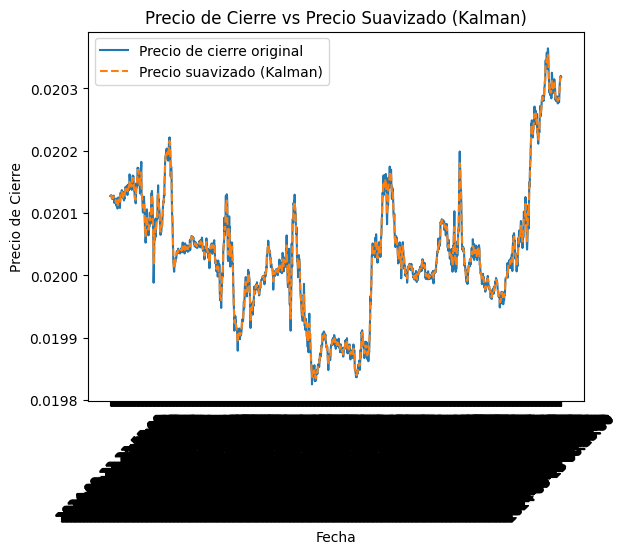

In [23]:
# Graficar los precios originales y los suavizados
plt.plot(df['date'], df['close'], label='Precio de cierre original')
plt.plot(df['date'], df['kalman_smoothed'], label='Precio suavizado (Kalman)', linestyle='--')

# Etiquetas y leyenda
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.title('Precio de Cierre vs Precio Suavizado (Kalman)')
plt.legend()
plt.xticks(rotation=45)
plt.show()